# Explorative Data Analysis - Seattle Public Life
Data credited to Seattle Open Data Portal [source](https://data.seattle.gov/browse/select_dataset?tags=sidewalks

| Year | Moving Observations | Staying Observations |
|------|--------------------|---------------------|
| 2018 |        1728        |        6537         |
| 2019 |        495         |        4179         |
| 2020 |         56         |         486         |
| 2022 |         99         |        1248         |



In [89]:
import pandas as pd 
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import Point, Polygon
import seaborn as sns

In [66]:
input_path = '/Users/gracejia/Documents/A-UW/dissertation/street_furniture/github/street_furniture/'
output_path = '/Users/gracejia/Documents/A-UW/dissertation/street_furniture/github/street_furniture/'
# Read the shapefile
geography = gpd.read_file(input_path + 'public_data/Public_Life_Data_Geography_20240122/geo_export_97ecd427-7823-4893-8c48-ef1c0afc6361.shp')
tracts_2010 = gpd.read_file(input_path + "public_data/Census_Tracts_2010.shp")
tracts_2010 = tracts_2010.to_crs(geography.crs)
sidewalks = gpd.read_file(input_path + "public_data/Sidewalks/Sidewalks.shp")
sidewalks = sidewalks.to_crs(geography.crs)
loc = pd.read_csv(input_path + "public_data/Public_Life_Data_-_Locations_20240122.csv")
moving = pd.read_csv(input_path + "public_data/Public_Life_Data_-_People_Moving_20240122.csv")
staying = pd.read_csv(input_path + "public_data/Public_Life_Data_-_People_Staying_20240122.csv")
# geography = geography.to_crs(epsg=4326)

helper functions

In [114]:
# helper functions
def create_moving_column(year):
    if year == 2018:
        return '2018-2019'
    elif year == 2019:
        return '2018-2019'
    elif year == 2020:
        return '2020'
    elif year == 2022:
        return '2022'

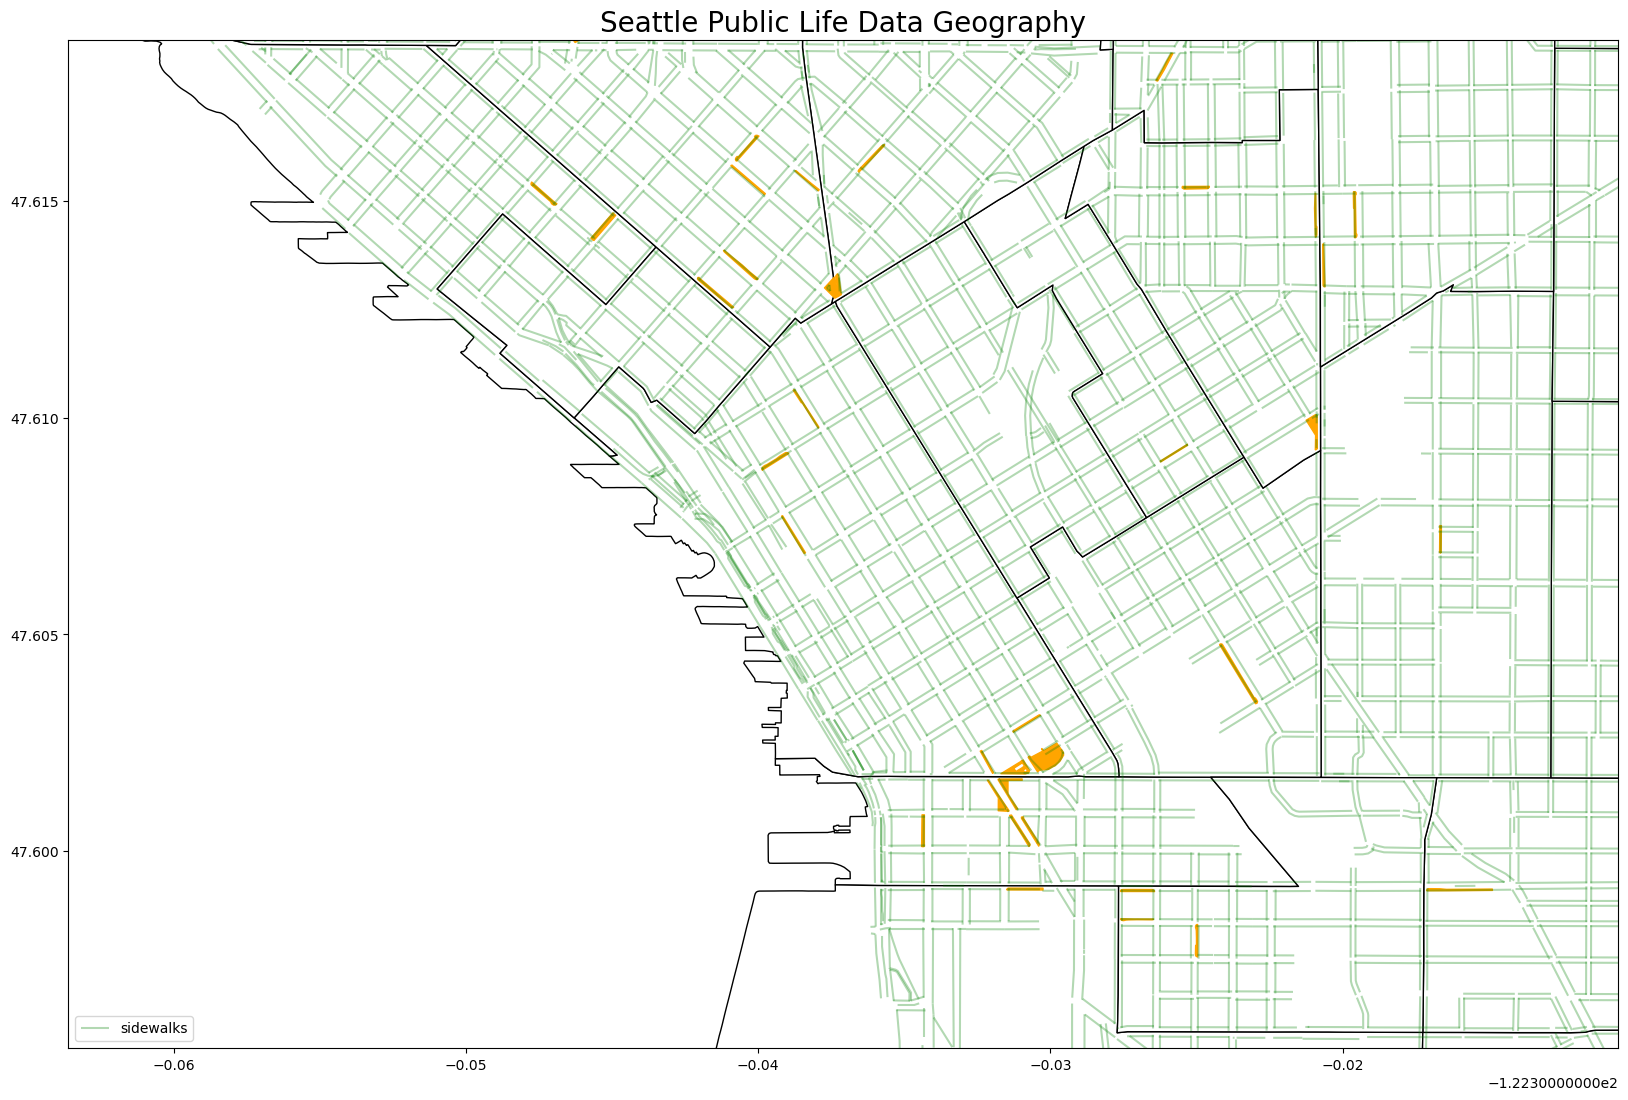

In [95]:
plt.figure(figsize=(20, 16))  # Adjust the figure size as needed

# Set the limits
x_min, x_max = -122.363604, -122.310561
y_min, y_max = 47.595458, 47.618721

# Plot tracts_2010 in light gray
tracts_2010.plot(ax=plt.gca(), color='white', edgecolor='black',label = 'census tracts 2010', legend = True)
sidewalks.plot(ax=plt.gca(), color='green', edgecolor='green',alpha = 0.3, label = 'sidewalks')
# Plot geography on top with orange color and adjusted transparency (alpha)
geography.plot(ax=plt.gca(), color='orange', edgecolor='orange', legend = True,label = 'study areas')

# Set plot title and show legend if needed
plt.title('Seattle Public Life Data Geography', fontsize = 20)
plt.legend(loc='lower left')  # Display the legend at the lower left corner

# Set the limits
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)

plt.show()

In [85]:
moving['moving_time_end'] = pd.to_datetime(moving['moving_time_end'])
moving['moving_time_start'] = pd.to_datetime(moving['moving_time_start'])
moving['dwell_time'] = moving['moving_time_end'] - moving['moving_time_start']

staying['staying_time_end'] = pd.to_datetime(staying['staying_time_end'])
staying['staying_time_start'] = pd.to_datetime(staying['staying_time_start'])
staying['dwell_time'] = staying['staying_time_end'] - staying['staying_time_start']



In [101]:
moving['moving_time_start'].dt.year.value_counts()
moving_year_counts = moving['moving_time_start'].dt.year.value_counts().reset_index()
moving_year_counts.columns = ['Year', 'Moving Observations']

staying_year_counts = staying['staying_time_start'].dt.year.value_counts().reset_index()
staying_year_counts.columns = ['Year', 'Staying Observations']

summary_table = pd.merge(moving_year_counts, staying_year_counts, on='Year', how='outer').fillna(0)
summary_table = summary_table.sort_values('Year')
summary_table


,Year,Moving Observations,Staying Observations
0,2018,1728,6537
1,2019,495,4179
3,2020,56,486
2,2022,99,1248


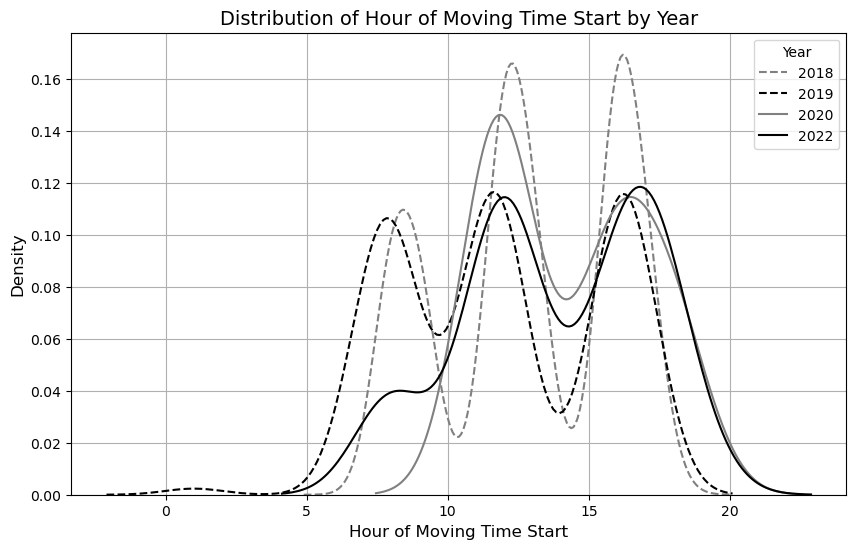

In [107]:
plt.figure(figsize=(10, 6))  # Increase the figure size

years = moving['moving_time_start'].dt.year.unique()  # Get unique years

# Define a color palette for each year
colors = ['grey', 'black', 'grey', 'black']

for i, year in enumerate(years):
    linestyle = '--' if year in [2018, 2019] else '-'
    color = colors[i]
    
    sns.kdeplot(moving[moving['moving_time_start'].dt.year == year]['moving_time_start'].dt.hour, 
                label=str(year), linestyle=linestyle, color=color)

plt.xlabel('Hour of Moving Time Start', fontsize=12)  # Adjust the font size of the x-axis label
plt.ylabel('Density', fontsize=12)  # Adjust the font size of the y-axis label
plt.title('Distribution of Hour of Moving Time Start by Year', fontsize=14)  # Adjust the font size of the title
plt.legend(title='Year', fontsize=10)  # Add a legend title and adjust the font size
plt.grid(True)  # Add gridlines to the plot
plt.show()



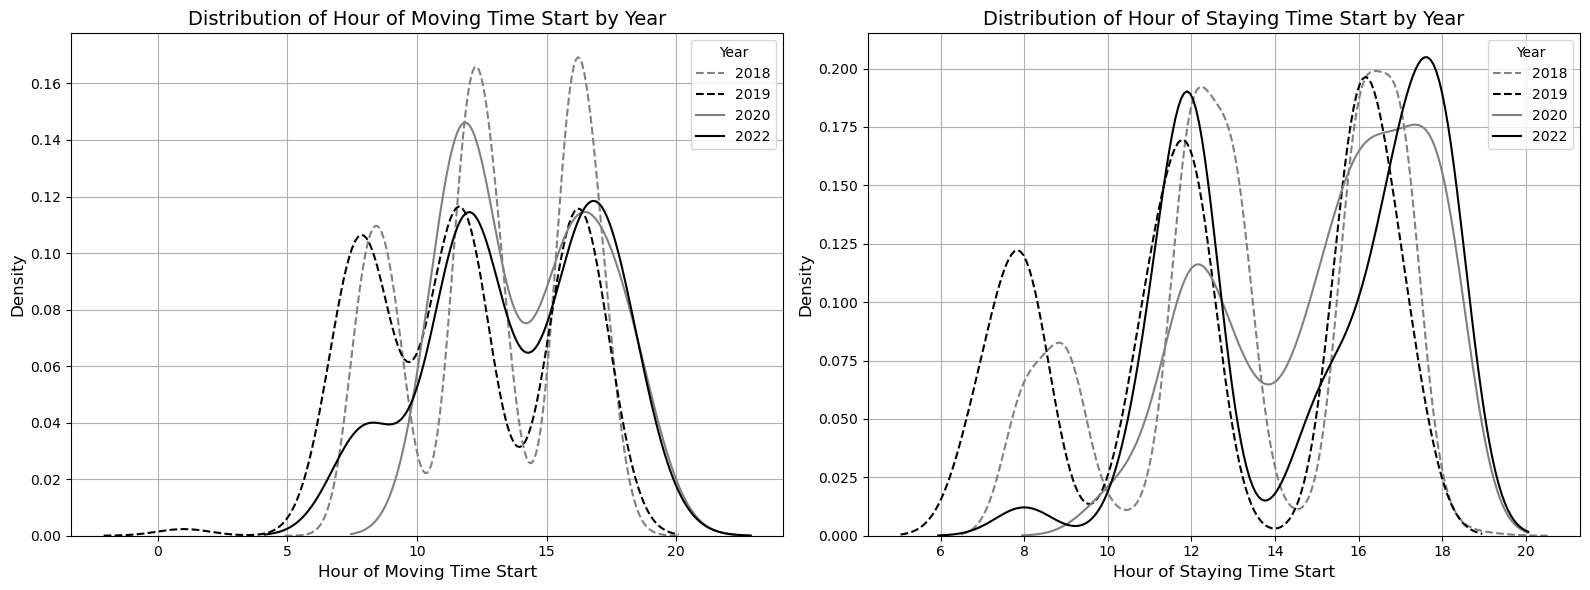

In [108]:
plt.figure(figsize=(16, 6))  # Increase the figure size

# Create subplots
ax1 = plt.subplot(1, 2, 1)
ax2 = plt.subplot(1, 2, 2)

# Plot distribution of hour of moving time start
years = moving['moving_time_start'].dt.year.unique()  # Get unique years
colors = ['grey', 'black', 'grey', 'black']

for i, year in enumerate(years):
    linestyle = '--' if year in [2018, 2019] else '-'
    color = colors[i]
    
    sns.kdeplot(moving[moving['moving_time_start'].dt.year == year]['moving_time_start'].dt.hour, 
                label=str(year), linestyle=linestyle, color=color, ax=ax1)

ax1.set_xlabel('Hour of Moving Time Start', fontsize=12)
ax1.set_ylabel('Density', fontsize=12)
ax1.set_title('Distribution of Hour of Moving Time Start by Year', fontsize=14)
ax1.legend(title='Year', fontsize=10)
ax1.grid(True)

# Plot distribution of hour of staying time start
years = staying['staying_time_start'].dt.year.unique()  # Get unique years
colors = ['grey', 'black', 'grey', 'black']

for i, year in enumerate(years):
    linestyle = '--' if year in [2018, 2019] else '-'
    color = colors[i]
    
    sns.kdeplot(staying[staying['staying_time_start'].dt.year == year]['staying_time_start'].dt.hour, 
                label=str(year), linestyle=linestyle, color=color, ax=ax2)

ax2.set_xlabel('Hour of Staying Time Start', fontsize=12)
ax2.set_ylabel('Density', fontsize=12)
ax2.set_title('Distribution of Hour of Staying Time Start by Year', fontsize=14)
ax2.legend(title='Year', fontsize=10)
ax2.grid(True)

plt.tight_layout()  # Adjust the spacing between subplots
plt.show()

In [116]:

moving['time_start_recoded'] = moving['moving_time_start'].dt.year.apply(create_moving_column)
staying['time_start_recoded'] = staying['staying_time_start'].dt.year.apply(create_moving_column)

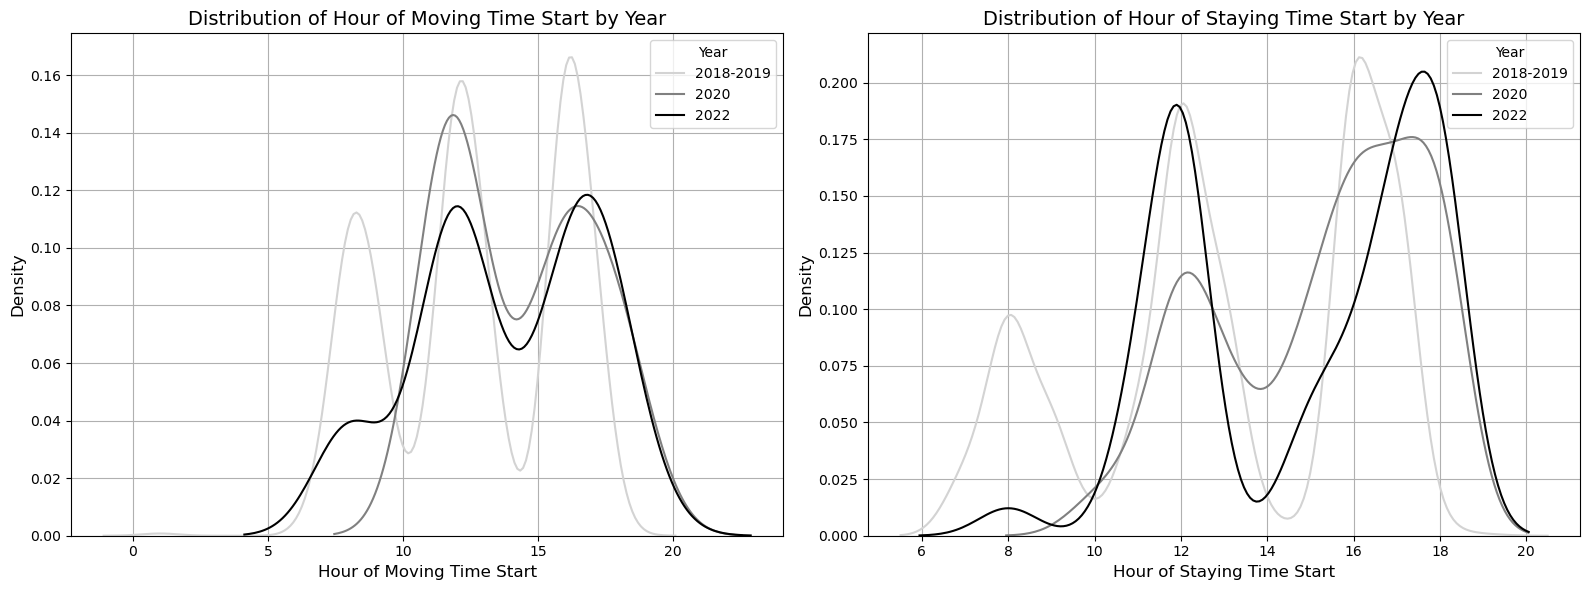

In [117]:
plt.figure(figsize=(16, 6))  # Increase the figure size

# Create subplots
ax1 = plt.subplot(1, 2, 1)
ax2 = plt.subplot(1, 2, 2)

# Plot distribution of hour of moving time start
years = moving['time_start_recoded'].unique()  # Get unique years
# colors = ['grey', 'black', 'grey', 'black']

for i, year in enumerate(years):
    if year == '2018-2019':
        color = 'lightgrey'
    elif year == '2020':
        color = 'grey'
    elif year == '2022':
        color = 'black'
    
    sns.kdeplot(moving[moving['time_start_recoded'] == year]['moving_time_start'].dt.hour, 
                label=str(year), linestyle=linestyle, color=color, ax=ax1)

ax1.set_xlabel('Hour of Moving Time Start', fontsize=12)
ax1.set_ylabel('Density', fontsize=12)
ax1.set_title('Distribution of Hour of Moving Time Start by Year', fontsize=14)
ax1.legend(title='Year', fontsize=10)
ax1.grid(True)

# Plot distribution of hour of staying time start
years = staying['time_start_recoded'].unique()  # Get unique years
# colors = ['grey', 'black', 'grey', 'black']

for i, year in enumerate(years):
    if year == '2018-2019':
        color = 'lightgrey'
    elif year == '2020':
        color = 'grey'
    elif year == '2022':
        color = 'black'
    
    sns.kdeplot(staying[staying['time_start_recoded'] == year]['staying_time_start'].dt.hour, 
                label=str(year), linestyle=linestyle, color=color, ax=ax2)

ax2.set_xlabel('Hour of Staying Time Start', fontsize=12)
ax2.set_ylabel('Density', fontsize=12)
ax2.set_title('Distribution of Hour of Staying Time Start by Year', fontsize=14)
ax2.legend(title='Year', fontsize=10)
ax2.grid(True)

plt.tight_layout()  # Adjust the spacing between subplots
plt.show()

In [137]:
geography['staying_count'] = geography['location_i'].map(staying.location_id.value_counts().to_dict())
geography['moving_count'] = geography['location_i'].map(moving.location_id.value_counts().to_dict())
geography['moving_count'].fillna(0, inplace=True)
geography['staying_count'].fillna(0, inplace=True)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


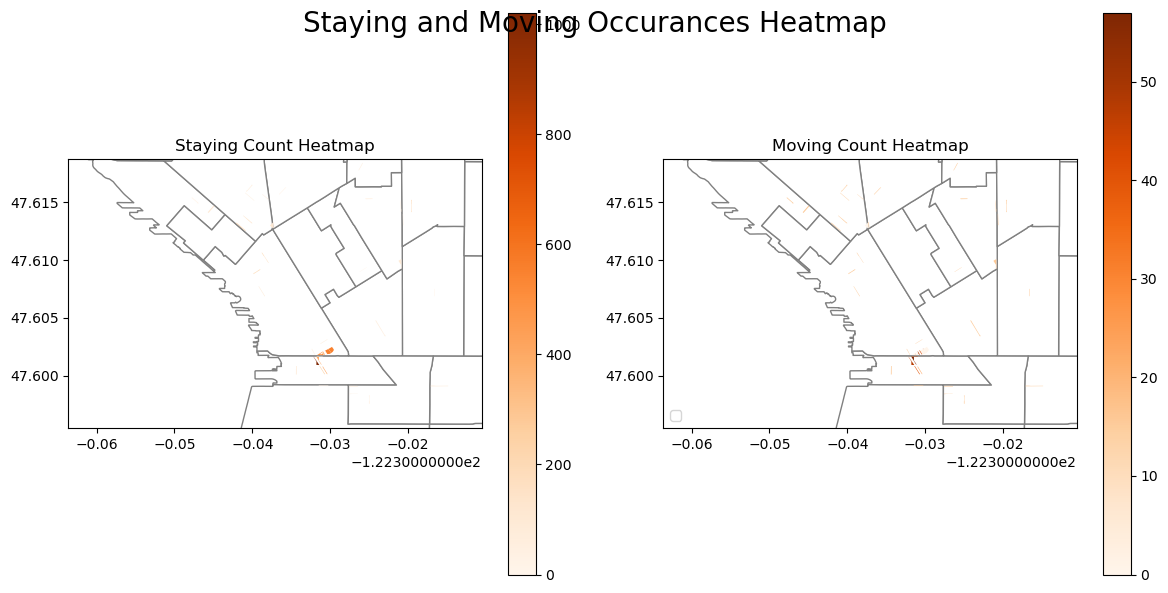

In [149]:
# Set plot title and show legend if needed
fig, axes = plt.subplots(1, 2, figsize=(12, 6))  # Create subplots with 1 row and 2 columns

# Plot heatmap for staying_count
# Plot tracts_2010 in light gray
tracts_2010.plot(ax=axes[0], color='white', edgecolor='gray',label = 'census tracts 2010', legend = True)
# sidewalks.plot(ax=axes[0], color='green', edgecolor='green',alpha = 0.3, label = 'sidewalks')
geography.plot(ax=axes[0],column='staying_count', cmap='Oranges', legend=True, label = 'staying')

axes[0].set_title('Staying Count Heatmap')  # Set the title for the first subplot
axes[0].set_xlabel('')  # Remove x-axis label for the first subplot
axes[0].set_ylabel('')  # Remove y-axis label for the first subplot
axes[0].set_xlim(x_min, x_max)  # Set x-limit for the first subplot
axes[0].set_ylim(y_min, y_max)  # Set y-limit for the first subplot

# Plot heatmap for moving_count
tracts_2010.plot(ax=axes[1], color='white', edgecolor='gray',label = 'census tracts 2010', legend = True)
# sidewalks.plot(ax=axes[1], color='green', edgecolor='green',alpha = 0.3, label = 'sidewalks')
geography.plot(ax=axes[1],column='moving_count', cmap='Oranges', legend=True, label = 'moving')
# Plot the heatmap on the second subplot

axes[1].set_title('Moving Count Heatmap')  # Set the title for the second subplot
axes[1].set_xlabel('')  # Remove x-axis label for the second subplot
axes[1].set_ylabel('')  # Remove y-axis label for the second subplot
axes[1].set_xlim(x_min, x_max)  # Set x-limit for the second subplot
axes[1].set_ylim(y_min, y_max)  # Set y-limit for the second subplot

plt.tight_layout()  # Adjust the spacing between subplots
plt.suptitle('Staying and Moving Occurances Heatmap', fontsize = 20)
# plt.legend(loc='lower left')  # Display the legend at the lower left corner
plt.show()

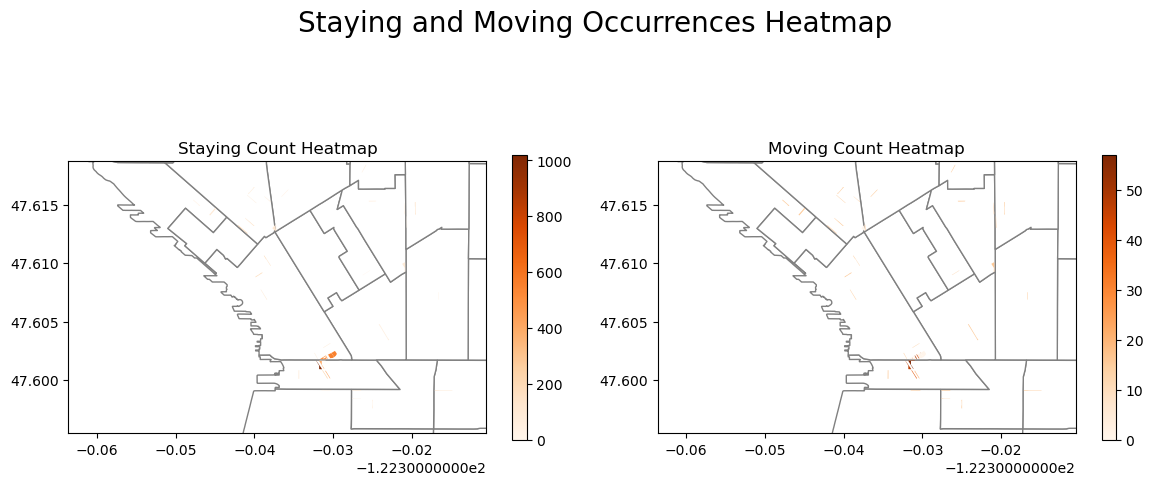

In [154]:

# Set plot title and show legend if needed
fig, axes = plt.subplots(1, 2, figsize=(12, 6))  # Create subplots with 1 row and 2 columns

# Plot heatmap for staying_count
tracts_2010.plot(ax=axes[0], color='white', edgecolor='gray',label='census tracts 2010', legend=True)
geography.plot(ax=axes[0], column='staying_count', cmap='Oranges', legend=True, label='staying',legend_kwds={'shrink': 0.5})

axes[0].set_title('Staying Count Heatmap')  # Set the title for the first subplot
axes[0].set_xlabel('')  # Remove x-axis label for the first subplot
axes[0].set_ylabel('')  # Remove y-axis label for the first subplot
axes[0].set_xlim(x_min, x_max)  # Set x-limit for the first subplot
axes[0].set_ylim(y_min, y_max)  # Set y-limit for the first subplot

# Place the legend outside the plot area
# legend_staying = axes[0].legend(loc='upper left', bbox_to_anchor=(1, 1), title='Legend')

# Plot heatmap for moving_count
tracts_2010.plot(ax=axes[1], color='white', edgecolor='gray',label='census tracts 2010', legend=True)
geography.plot(ax=axes[1], column='moving_count', cmap='Oranges', legend=True, label='moving',legend_kwds={'shrink': 0.5})

axes[1].set_title('Moving Count Heatmap')  # Set the title for the second subplot
axes[1].set_xlabel('')  # Remove x-axis label for the second subplot
axes[1].set_ylabel('')  # Remove y-axis label for the second subplot
axes[1].set_xlim(x_min, x_max)  # Set x-limit for the second subplot
axes[1].set_ylim(y_min, y_max)  # Set y-limit for the second subplot

# Place the legend outside the plot area
# legend_moving = axes[1].legend(loc='upper left', bbox_to_anchor=(1, 1), title='Legend')

plt.tight_layout()  # Adjust the spacing between subplots
plt.suptitle('Staying and Moving Occurrences Heatmap', fontsize=20)

plt.show()